# Assessing Corpus Quality
### In this notebook, we'll learn about assessing corpus quality and potentially correcting problems. 
## Potential Problem areas
1. Unexpected characters
1. Improperly joined words
1. Loanwords
### We will consider each of these in turn.
### Datasets: We'll be using the freely available CLTK datasets of the Latin Library and Perseus Latin texts, but the techniques in this notebook will apply to other languages as well.
#### set up the notebook

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### A few open source imports

In [3]:
from collections import Counter, defaultdict
import re
from bisect import bisect
import statistics

from cltk.corpus.readers import get_corpus_reader
from cltk.stem.latin.j_v import JVReplacer
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.style.use('fivethirtyeight')

### Add parent directory to path so we can access our common code

In [4]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [5]:
from mlyoucanuse.corpus_analysis_fun import (get_word_lengths,
                                             get_samples_for_lengths,
                                             get_char_counts,
                                             get_mean_stdev)

## The Latin Library Corpus

In [4]:
latin_library_reader = get_corpus_reader(corpus_name='latin_text_latin_library', language='latin')

## The Perseus Latin Corpus

In [5]:
perseus_latin_reader = get_corpus_reader(corpus_name='latin_text_perseus', language='latin')

### 1. Unexpected Characters
#### Let's have a look at the characters: Grab all the words, check if they are alphabetical, and count them

In [6]:
latin_lib_char_freq = get_char_counts(latin_library_reader)
print(f'Latin Library Corpus: Number of characters: {sum(latin_lib_char_freq.values()):,}')
print('Latin Library character frequency distribution:', latin_lib_char_freq)
#####################
perseus_latin_char_freq = get_char_counts(perseus_latin_reader)
print(f'Perseus Latin Corpus: Number of characters: {sum(perseus_latin_char_freq.values()):,}')
print('Perseus Latin character frequency distribution:', perseus_latin_char_freq)


  0%|          | 0/293 [00:00<?, ?files/s]

Latin Library Corpus: Number of characters: 75,451,171
Latin Library character frequency distribution: Counter({'e': 8576123, 'i': 8573678, 't': 6306262, 'a': 6258185, 'u': 6106664, 's': 5695715, 'r': 4717114, 'n': 4700797, 'o': 4184861, 'm': 3968984, 'c': 2826383, 'd': 2323221, 'l': 2220037, 'p': 2046252, 'b': 1052786, 'q': 1000896, 'v': 764958, 'g': 761427, 'f': 676516, 'h': 536389, 'x': 341117, 'I': 205845, 'A': 153068, 'S': 134701, 'C': 130344, 'D': 119576, 'P': 107924, 'E': 90935, 'N': 74718, 'T': 73036, 'M': 69371, 'R': 64627, 'V': 64109, 'H': 58901, 'Q': 57106, 'y': 56645, 'L': 56146, 'X': 42245, 'O': 41873, 'U': 38028, 'G': 35341, 'B': 28814, 'F': 26066, 'j': 19535, 'æ': 8938, 'z': 6607, 'k': 5944, 'J': 5182, 'K': 2833, 'w': 2767, 'Y': 2480, 'Z': 1969, 'ν': 1809, 'W': 1672, 'τ': 1613, 'α': 1509, 'ο': 1445, 'ε': 1064, 'ι': 1042, 'ê': 882, 'ς': 782, 'ρ': 770, 'â': 743, 'π': 712, 'κ': 684, 'μ': 667, 'σ': 638, 'λ': 553, 'δ': 527, 'ὶ': 333, 'ω': 322, 'ί': 313, 'υ': 302, 'γ': 296, 'έ

100%|██████████| 293/293 [02:41<00:00,  6.91files/s]1%|          | 2/293 [00:05<15:47,  3.25s/files]


Perseus Latin Corpus: Number of characters: 22,570,613
Perseus Latin character frequency distribution: Counter({'e': 2573626, 'i': 2540681, 'a': 1950909, 't': 1859409, 'u': 1826139, 's': 1713549, 'r': 1424121, 'n': 1384612, 'm': 1239489, 'o': 1230708, 'c': 856902, 'l': 695765, 'd': 680521, 'p': 593449, 'q': 322142, 'b': 314761, 'v': 258914, 'g': 232105, 'f': 208419, 'h': 168682, 'x': 104819, 'A': 35456, 'C': 33845, 'I': 32417, 'S': 29175, 'P': 25424, 'y': 22051, 'N': 17196, 'M': 17033, 'T': 16179, 'E': 15970, 'H': 13570, 'V': 13223, 'L': 12281, 'Q': 12187, 'D': 11757, 'R': 11549, 'G': 9311, 'O': 6775, 'F': 6029, 'B': 5992, 'X': 5248, 'U': 2926, 'é': 2180, 'í': 1803, 'ν': 1785, 'α': 1656, 'ο': 1615, 'j': 1518, 'á': 1477, 'σ': 1402, 'ó': 1286, 'ι': 1285, 'τ': 1281, 'z': 1267, 'ú': 1170, 'ε': 1152, 'ρ': 1015, 'π': 852, 'λ': 748, 'μ': 748, 'κ': 671, 'Z': 641, 'K': 573, 'δ': 501, 'υ': 460, 'η': 369, 'γ': 355, 'ί': 337, 'χ': 334, 'ς': 315, 'ω': 315, 'θ': 301, 'φ': 295, 'ἀ': 290, 'ë': 266, 'έ

## We can see some obvious dirtiness:
1. There are two characters 'œ' and 'æ' that represent dipthongs which should be split into two characters.
1. There are some Greek letters in a Greek font, and some accented vowels foreign to Greek and Latin.

#### Let's consider these items the start of a bread crumb trail towards something bad and let's look further. 

## 1. OE and AE 
#### Classical Latin wrote the o and e separately (as has today again become the general practice), but the ligature was used by medieval and early modern writings, in part because the diphthongal sound had, by Late Latin, merged into the sound [e].
#### https://en.wikipedia.org/wiki/%C5%92

#### Æ (minuscule: æ) is a grapheme named æsc or ash, formed from the letters a and e, originally a ligature representing the Latin diphthong ae. It has been promoted to the full status of a letter in the alphabets of some languages, including Danish, Norwegian, Icelandic, and Faroese. 
#### https://en.wikipedia.org/wiki/%C3%86

#### We have written an AEOEReplacer in the style of the CLTK JVReplacer and will use this to clean the corpora in other notebooks.

## 2. Greek Letters, Greek words; Foreign characters
### Filtering out these Greek words and obvious characters is easy

In [7]:
foreign_characters = [ tmp for tmp in 
                        perseus_latin_char_freq.keys()
                        if not re.match('[a-zA-Z]', tmp) ]
print('foreign_characters', foreign_characters)

just_latin_words = []
latin_library_reader = get_corpus_reader(corpus_name='latin_text_latin_library', language='latin')
for word in tqdm(latin_library_reader.words()):
    if not re.match('[{}]'.format(''.join(foreign_characters)), word):
        just_latin_words.append(word)

print(f'Number just latin words: {len(just_latin_words):,}')

0it [00:00, ?it/s]136it [00:00, 1350.96it/s]

foreign_characters ['φ', 'α', 'ν', 'τ', 'σ', 'ί', 'ς', 'ἔ', 'λ', 'β', 'ε', 'π', 'ο', 'ρ', 'ύ', 'ά', 'κ', 'ὶ', 'μ', 'ῖ', 'ι', 'ή', 'δ', 'ἱ', 'ό', 'υ', 'ῳ', 'ῷ', 'χ', 'ἄ', 'ῃ', 'ἀ', 'ω', 'θ', 'ζ', 'ὐ', 'ὰ', 'η', 'γ', 'ὸ', 'ἷ', 'ἐ', 'ἶ', 'έ', 'ὺ', 'ὲ', 'ὴ', 'ῆ', 'ἴ', 'ὁ', 'ῶ', 'ῦ', 'ώ', 'ἰ', 'ῇ', 'ὀ', 'ξ', 'ʽ', 'ᾶ', 'ὃ', 'ʼ', 'ᾧ', 'ὑ', 'ἡ', 'ἑ', 'ὼ', 'ὗ', 'ᾷ', 'ᾳ', 'ἠ', 'ὅ', 'ἕ', 'ἅ', 'ὔ', 'ώ', 'ύ', 'ά', 'Ἀ', 'ί', 'ë', 'έ', 'ἥ', 'ό', 'Δ', 'ὕ', 'Κ', 'Α', 'Ὄ', 'Μ', 'Φ', 'Β', 'ή', 'Τ', 'ἲ', 'ῤ', 'Χ', 'Θ', 'Ψ', 'Λ', 'Ἑ', 'Ἄ', 'Ι', 'ψ', 'Π', 'ἤ', 'Ο', 'Σ', 'Ῥ', 'Ὀ', 'Ξ', 'Ϡ', 'Ε', 'Ω', 'ὄ', 'ὦ', 'ὤ', 'ᾠ', 'ὥ', 'ὠ', 'ἆ', 'ü', 'é', 'ↄ', 'ú', 'í', 'á', 'ó', 'Í', 'ý', 'œ', 'Ó', 'ϊ', 'ΐ', 'Ↄ', 'Ἡ', 'ἧ', 'É', 'ἂ', 'ὢ', 'ἦ', 'ἢ', 'ἁ', 'ἓ', 'Γ', 'ἵ', 'ὖ', 'ὧ', 'Ἐ', 'Ἰ', 'Ἕ', 'ὡ', 'Ν', 'Ζ', 'ἳ', 'à', 'ï', 'а', 'е', 'м', 'Ш', 'о', 'С', 'î', 'Á', 'Ἆ', 'ē', 'ϝ', 'ῥ', 'Å', 'ϋ', 'æ', 'Ἤ', 'Ὦ', 'Î', 'ů', 'Υ', 'Ρ', 'ö', 'û', 'Ἁ']


16455728it [15:05, 18170.19it/s] [00:00, 2421.71it/s]

Number just latin words: 16,450,347


### This is easily extended to "Show me all the Greek in Cicero", "Show me Plautus without Greek", etc.
#### But other problems lurk: such as 
## Acceptable Characters may represent foreign words transliterated:

In [8]:
'kai' in just_latin_words # kai means 'and' in Greek

True

### We will deal with the complex problem of detecting and correcting transliterated loadwords in another notebook

## Simple Heuristic for detecting improperly joined words
### Almost always when a sequence of lower case letters is followed by a capital letter without a space intervening it is an indicator of improperly joined words.

In [9]:
camelCase_regex = '[a-z]+[A-Z][a-z]+'

for word in just_latin_words[:10000]:
    if re.match(camelCase_regex, word):
        print (word)

camel_case_count = 0

for word in tqdm(just_latin_words):
    if re.match(camelCase_regex, word):
        camel_case_count +=1 

print(f'Number of camel cased words {camel_case_count:,}')        
        

  0%|          | 0/16450347 [00:00<?, ?it/s]

naviIndica
quaeGoa
seuMadagascar
digitiIndici
aureaMozambici
anniDecembri
quiCafres
suntCafres
osCafres
estBazaini
cantaturPraefatio


100%|██████████| 16450347/16450347 [00:24<00:00, 659738.78it/s]%|          | 114161/16450347 [00:00<00:28, 575202.76it/s]

Number of camel cased words 516


## camelCased words are easily corrected
### e.g.:
#### from cltk.util.matrix_corpus_fun import split_camel
at: https://github.com/cltk/cltk/blob/master/cltk/utils/matrix_corpus_fun.py#L213

## Detecting Improperly Joined Words In General
* Errors in data transmission, 
* Improperly OCRed text
* botched formating (e.g. blindly joining lines and dropping newline characters that are also meant to encode word separations)

#### Can all cause words to become improperly joined in a corpus.
#### To help spot candidates of improperly joined words, we need to first examine some sample corpora to determine typical word lengths.

In [10]:
latin_lib_lengths = get_word_lengths(latin_library_reader)

100%|██████████| 2141/2141 [7:52:48<00:00,  1.33files/s]     /2141 [00:00<06:48,  5.24files/s]


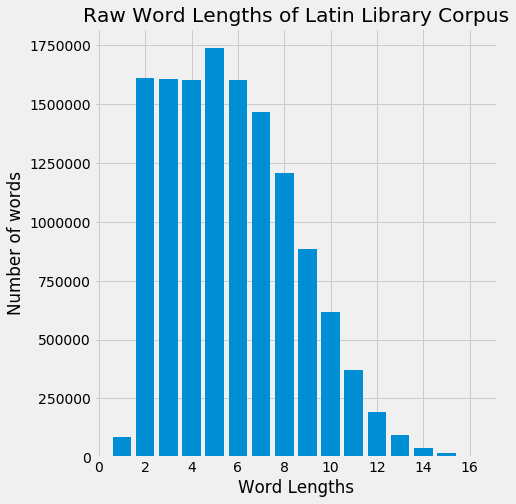

In [33]:
top_label, side_label, bottom_label = ( 'Word Lengths', 'Number of words',
                                       'Raw Word Lengths of Latin Library Corpus')
fig = plt.figure(figsize=(7,7))
plt.xlabel(top_label)
plt.ylabel(side_label)
plt.title(bottom_label)
ax = fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
data = list(latin_lib_lengths.items())
data.sort(key=lambda k: k[0])
indices, values = zip(*data)
idx= bisect(indices, 28) 
# expert testimony, reasonably longest words:
# undēquinquāgēsimōrum = 24 letters
# conscrībillātūrōrum
# percrēbrēscēbāminī
indices, values = zip(*data[:idx]) # reasonably longest word in latin 
indices, values = zip(*data[:16]) # Nothing shows up on the graph beyond this range
plt.bar(indices, values)
plt.tight_layout(pad=0.5, w_pad=20, h_pad=0.5)
plt.show()

In [17]:
total_words = sum(latin_lib_lengths.values())
print(f'Total words {total_words:,}')
print('Word lengths:', latin_lib_lengths)
mean_word_len, stdev_word_length = get_mean_stdev(latin_lib_lengths)
print(f'Mean Latin word length: {round(mean_word_len, 2)}, standard deviation: {round(stdev_word_length, 2)}')
print(f'98% cutoff {round(mean_word_len + (2* stdev_word_length))} letters')

Total words 13,137,256
Word lengths: Counter({5: 1736309, 2: 1608422, 3: 1605589, 4: 1601042, 6: 1600574, 7: 1466665, 8: 1207092, 9: 882205, 10: 615554, 11: 371324, 12: 192327, 13: 94100, 1: 87346, 14: 41324, 15: 17094, 16: 6702, 17: 2162, 18: 575, 19: 354, 20: 289, 21: 86, 22: 45, 23: 38, 25: 12, 26: 7, 24: 6, 28: 6, 30: 1, 27: 1, 48: 1, 32: 1, 36: 1, 29: 1, 39: 1})
Mean Latin word length: 5.74, standard deviation: 2.76
98% cutoff 11 letters


In [18]:
perseus_latin_lengths = get_word_lengths(perseus_latin_reader) 

100%|██████████| 293/293 [02:50<00:00,  6.41files/s]     | 1/293 [00:04<21:21,  4.39s/files]


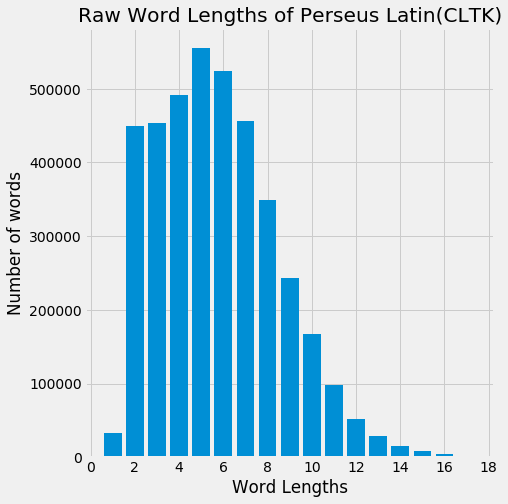

In [31]:
top_label, side_label, bottom_label = ('Word Lengths', 'Number of words',
                                       'Raw Word Lengths of Perseus Latin(CLTK)')
fig = plt.figure(2, figsize=(7,7))
ax = fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(top_label)
plt.ylabel(side_label)
plt.title(bottom_label )
data = list(perseus_latin_lengths.items())
data.sort(key=lambda k: k[0])
indices, values = zip(*data)
idx = bisect(indices, 28) 
indices, values = zip(*data[:16]) # reasonably Longest word in latin 
# print(indices)
# print(values)
plt.bar(indices, values)
plt.tight_layout(pad=0.5, w_pad=20, h_pad=0.5)
plt.show();

In [23]:
total_words = sum(perseus_latin_lengths.values())
print(f'Total words {total_words:,}')
print('Word Lengths', perseus_latin_lengths)
mean_word_len, stdev_word_length = get_mean_stdev(perseus_latin_lengths)
print(f'Mean Latin word length: {round(mean_word_len, 2)}, standard deviation: {round(stdev_word_length, 2)}')
print(f'98% cutoff {round(mean_word_len + (2* stdev_word_length))} letters')

Total words 3,932,338
Word Lengths Counter({5: 554740, 6: 524202, 4: 491842, 7: 456598, 3: 453098, 2: 449547, 8: 349433, 9: 242573, 10: 166776, 11: 97863, 12: 52377, 1: 33003, 13: 28622, 14: 15548, 15: 8358, 16: 4370, 17: 1942, 18: 864, 19: 287, 20: 146, 21: 64, 22: 41, 23: 16, 24: 10, 25: 7, 28: 3, 38: 2, 26: 2, 31: 1, 33: 1, 32: 1, 34: 1})
Mean Latin word length: 5.74, standard deviation: 2.73
98% cutoff 11 letters


### Based on these numbers we can see that the long words in the Latin corpora are exceptional, and we can take a reasonable stance that any word in a corpus 12 letters or longer is a candidate for examination to determine whether or not it's an improperly joined word. Let's take a closer look at their representations.

## Breaking long words in two when possible, to do this we'll need to 
### Build a language model that will help us find word boundaries and vet candidates for un-merging, this is the task in another notebook `make_trie_language_model.ipynb`.
### In another notebook, `detecting_and_correcting_loanwords.ipynb` we will take on the complex problem of transliterated loanwords.

## That's all for now folks!